ResNeXt

Setup environment

In [145]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda:", torch.cuda.is_available())

# Directory paths in the local machine
test_data_path = "./Dataset/test"
combined_data_path = "./Dataset/train"

# for reproducibility and quick adjustments
torch.manual_seed(0)
batch_size = 32


cuda: True


Prep the training and validation datasets

In [146]:

# Define the Transformations
# Include resizing the images, converting them to tensor, and normalizing.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 as required
    transforms.ToTensor(),  # Convert image to tensor
    # Normalize using mean and std of the ImageNet dataset - recommended by ChatGPT
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the Datasets
# Use torchvision's ImageFolder to load the dataset.
# ImageFolder expects data to be structured in a specific way.
combined_dataset = datasets.ImageFolder(root=combined_data_path, transform=transform)
train_size = int(0.8 * len(combined_dataset))   # size of the training set: 80%
val_size = len(combined_dataset) - train_size   # size of the validation set
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Prep the testing dataset

In [147]:

# Custom dataset loader to handle unlabeled data.
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_list[idx]

test_dataset = UnlabeledDataset(root_dir=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Setup Model with ResNeXt

In [148]:
# Load a pre-trained ResNeXt model (or resnext101_32x8d)
# model = models.resnext50_32x4d(pretrained=True)
model = models.resnext101_32x8d(pretrained=True)

# Replace the last fully connected layer
num_features = model.fc.in_features  # Get the number of inputs for the last layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # 50% of the neurons are dropped out
    nn.Linear(num_features, 100)
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True

# # Unfreeze additional layers
# for name, child in model.named_children():
#     if name in ['layer4']:  # Unfreeze 'layer4'
#         for param in child.parameters():
#             param.requires_grad = True

model = model.to(device)


Define Loss Function and Optimizer

In [149]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # weight_decay is L2 regularization
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


Training and Validation Loop

In [150]:
# Keep track of training loss and validation accuracy
train_losses = []
val_accuracies = []

num_epochs = 20
# num_epochs = 1  # debug

for epoch in range(num_epochs):

    # Set the model to training mode
    # This enables layers like dropout and batch normalization to behave correctly.
    model.train()
    
    # Track loss of each epoch
    total_loss = 0

    # Loop over each batch from the training set
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move images and labels to the correct device
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute the model output
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients

        # Update the model parameters
        optimizer.step()
        
        total_loss += loss.item()
    # Calculate average loss over an epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Set Model to Evaluation Mode
    # This disables layers like dropout.
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    val_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {epoch_accuracy:.2f}%')



Epoch [1/20], Loss: 4.4446, Validation Accuracy: 23.61%
Epoch [2/20], Loss: 2.6896, Validation Accuracy: 40.74%
Epoch [3/20], Loss: 1.8386, Validation Accuracy: 46.76%
Epoch [4/20], Loss: 1.4280, Validation Accuracy: 48.15%
Epoch [5/20], Loss: 1.1835, Validation Accuracy: 54.17%
Epoch [6/20], Loss: 0.9656, Validation Accuracy: 52.78%
Epoch [7/20], Loss: 0.8210, Validation Accuracy: 56.02%
Epoch [8/20], Loss: 0.7094, Validation Accuracy: 55.56%
Epoch [9/20], Loss: 0.6492, Validation Accuracy: 56.48%
Epoch [10/20], Loss: 0.5600, Validation Accuracy: 55.56%
Epoch [11/20], Loss: 0.5121, Validation Accuracy: 58.80%
Epoch [12/20], Loss: 0.4531, Validation Accuracy: 58.33%
Epoch [13/20], Loss: 0.4226, Validation Accuracy: 59.72%
Epoch [14/20], Loss: 0.4030, Validation Accuracy: 61.11%
Epoch [15/20], Loss: 0.3544, Validation Accuracy: 58.33%
Epoch [16/20], Loss: 0.3283, Validation Accuracy: 58.80%
Epoch [17/20], Loss: 0.2892, Validation Accuracy: 56.94%
Epoch [18/20], Loss: 0.2781, Validation 

Plotting Training Loss and Training Accuracy

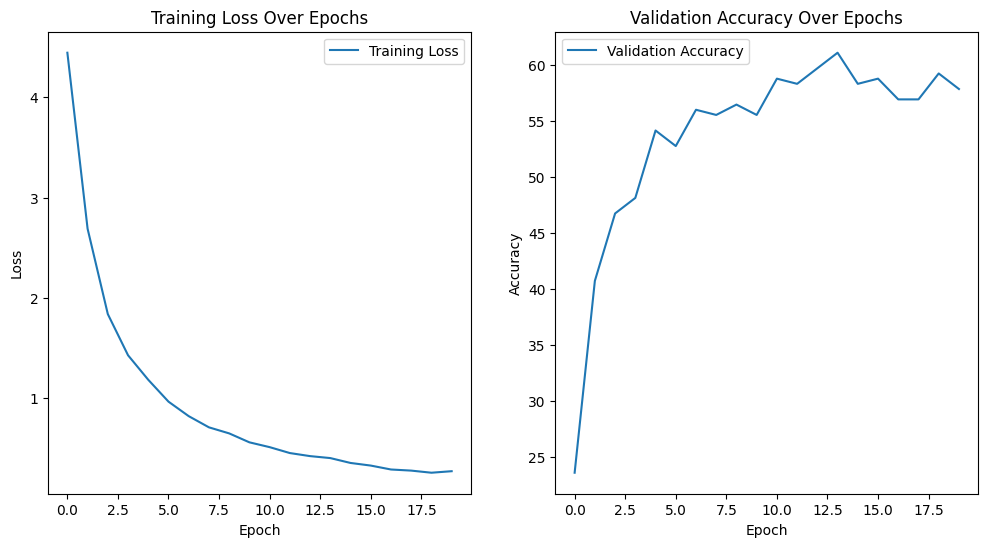

In [151]:
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()


Run on the test dataset to create the predictions

In [152]:
model.eval()

predictions = []
file_names = []

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_names.extend(names)

Save predictions onto a CSV File

In [153]:
# Create a DataFrame
submission_df = pd.DataFrame({
    'ID': file_names,
    'Label': predictions
})

# Save the DataFrame as a CSV file
submission_csv_path = './CSV Files/submission.csv'
submission_df.to_csv(submission_csv_path, index=False)

print("CSV file saved:", submission_csv_path)


CSV file saved: ./CSV Files/submission.csv
